In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'UMI.BR'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2003-06-30,2357,-1826,531,34,129,631,906,1696,0,...,0,0,737,1453,36,1915,132,-391,254.20,2003-07-21
1,2003-12-31,2357,-1826,531,34,129,631,906,1696,0,...,0,0,737,1453,36,1915,132,-391,254.20,2004-02-14
2,2004-06-30,3585,-2872,713,91,154,727,963,1883,0,...,0,0,329,1155,414,1975,161,-68,256.22,2004-07-21
3,2004-12-31,3585,-2872,713,91,154,727,963,1883,0,...,0,0,329,1155,414,1975,161,-68,256.22,2005-02-14
4,2005-06-30,3319,-2704,615,77,272,662,811,1753,0,...,0,0,418,1180,281,1942,130,-62,255.14,2005-07-21


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
38,2022-06-30,2022-07-21,241.05,12890,-12055,835,310,1478,2380,3143,...,343,10259,0,0,793,4553,1640,6849,422,-201
39,2022-12-31,2023-02-14,240.40,12546,-11727,818,262,1240,1831,3394,...,343,9942,0,0,717,4134,1626,6426,212,-290
40,2023-06-30,2023-07-21,240.43,10012,-9211,800,220,1373,1795,2969,...,382,9860,0,0,729,3613,2007,6265,274,-349
41,2023-12-31,2024-02-14,240.43,8254,-7549,705,157,1516,1357,2850,...,381,9966,0,0,729,3596,2019,6305,768,-536
42,2023-06-01,2024-06-10,240.43,8125,-7549,705,157,1516,1357,2850,...,381,9966,0,0,729,3596,2019,7050,768,-536


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

EUR=X: Data doesn't exist for startDate = 1049151600, endDate = 1056927600
/Users/zsolt.nagy/Desktop/projects/Economy/valueinvesting/utils.py:52: RuntimeWarning: Mean of empty slice.
  result_series.append(data[columns].values.mean())
/Users/zsolt.nagy/Desktop/projects/Economy/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
38,2022-06-30,2022-07-21,241.05,12890,-12055,835,310,1478,2380,3143,...,10259,0,0,793,4553,1640,6849,422,-201,0.938325
39,2022-12-31,2023-02-14,240.40,12546,-11727,818,262,1240,1831,3394,...,9942,0,0,717,4134,1626,6426,212,-290,0.980663
40,2023-06-30,2023-07-21,240.43,10012,-9211,800,220,1373,1795,2969,...,9860,0,0,729,3613,2007,6265,274,-349,0.918362
41,2023-12-31,2024-02-14,240.43,8254,-7549,705,157,1516,1357,2850,...,9966,0,0,729,3596,2019,6305,768,-536,0.929674
42,2023-06-01,2024-06-10,240.43,8125,-7549,705,157,1516,1357,2850,...,9966,0,0,729,3596,2019,7050,768,-536,0.921854


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
38,2022-06-30,2022-07-21,241.05,12890,-12055,835,310,1478,2380,3143,...,10259,0,0,793,4553,1640,6849,422,-201,0.938325
39,2022-12-31,2023-02-14,240.40,12546,-11727,818,262,1240,1831,3394,...,9942,0,0,717,4134,1626,6426,212,-290,0.980663
40,2023-06-30,2023-07-21,240.43,10012,-9211,800,220,1373,1795,2969,...,9860,0,0,729,3613,2007,6265,274,-349,0.918362
41,2023-12-31,2024-02-14,240.43,8254,-7549,705,157,1516,1357,2850,...,9966,0,0,729,3596,2019,6305,768,-536,0.929674
42,2023-06-01,2024-06-10,240.43,8125,-7549,705,157,1516,1357,2850,...,9966,0,0,729,3596,2019,7050,768,-536,0.921854


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr, report='half-year')

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr, report='half-year')

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2004-02-16,3.330209,2003-12-31,2357.0,0.0,4.697089,254.2,0.0,0.0,129.0,...,0.384046,0.615954,0.0,0.0,0.0,0.0,0.225286,0.014425,0.0,0.0
1,2004-02-23,3.281548,2003-12-31,2357.0,0.0,4.697089,254.2,0.0,0.0,129.0,...,0.384046,0.615954,0.0,0.0,0.0,0.0,0.225286,0.014425,0.0,0.0
2,2004-03-01,3.400158,2003-12-31,2357.0,0.0,4.697089,254.2,0.0,0.0,129.0,...,0.384046,0.615954,0.0,0.0,0.0,0.0,0.225286,0.014425,0.0,0.0
3,2004-03-08,3.153814,2003-12-31,2357.0,0.0,4.697089,254.2,0.0,0.0,129.0,...,0.384046,0.615954,0.0,0.0,0.0,0.0,0.225286,0.014425,0.0,0.0
4,2004-03-15,3.062575,2003-12-31,2357.0,0.0,4.697089,254.2,0.0,0.0,129.0,...,0.384046,0.615954,0.0,0.0,0.0,0.0,0.225286,0.014425,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr, report='half-year')
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2004-02-16,3.330209,2003-12-31,2357.0,0.0,4.697089,254.2,0.0,0.0,129.0,...,0.0,0.225286,0.014425,0.0,0.0,inf,0.708994,0.179580,0.558451,inf
1,2004-02-23,3.281548,2003-12-31,2357.0,0.0,4.697089,254.2,0.0,0.0,129.0,...,0.0,0.225286,0.014425,0.0,0.0,inf,0.698634,0.176956,0.555827,inf
2,2004-03-01,3.400158,2003-12-31,2357.0,0.0,4.697089,254.2,0.0,0.0,129.0,...,0.0,0.225286,0.014425,0.0,0.0,inf,0.723886,0.183352,0.562223,inf
3,2004-03-08,3.153814,2003-12-31,2357.0,0.0,4.697089,254.2,0.0,0.0,129.0,...,0.0,0.225286,0.014425,0.0,0.0,inf,0.671440,0.170068,0.548939,inf
4,2004-03-15,3.062575,2003-12-31,2357.0,0.0,4.697089,254.2,0.0,0.0,129.0,...,0.0,0.225286,0.014425,0.0,0.0,inf,0.652016,0.165148,0.544019,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

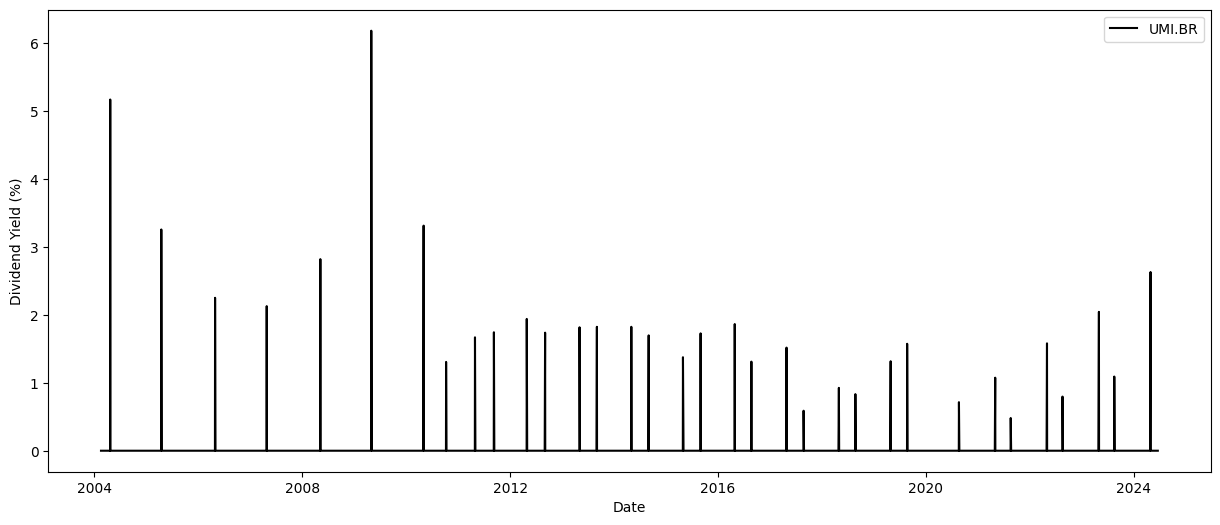

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.571835
share_price      1.000000
Name: share_price, dtype: float64


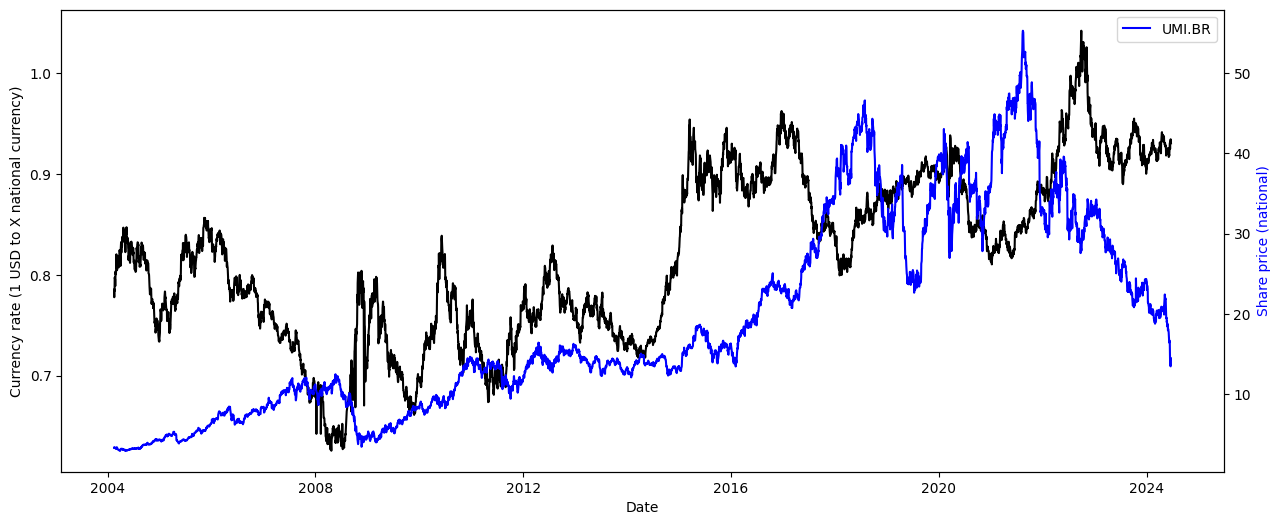

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

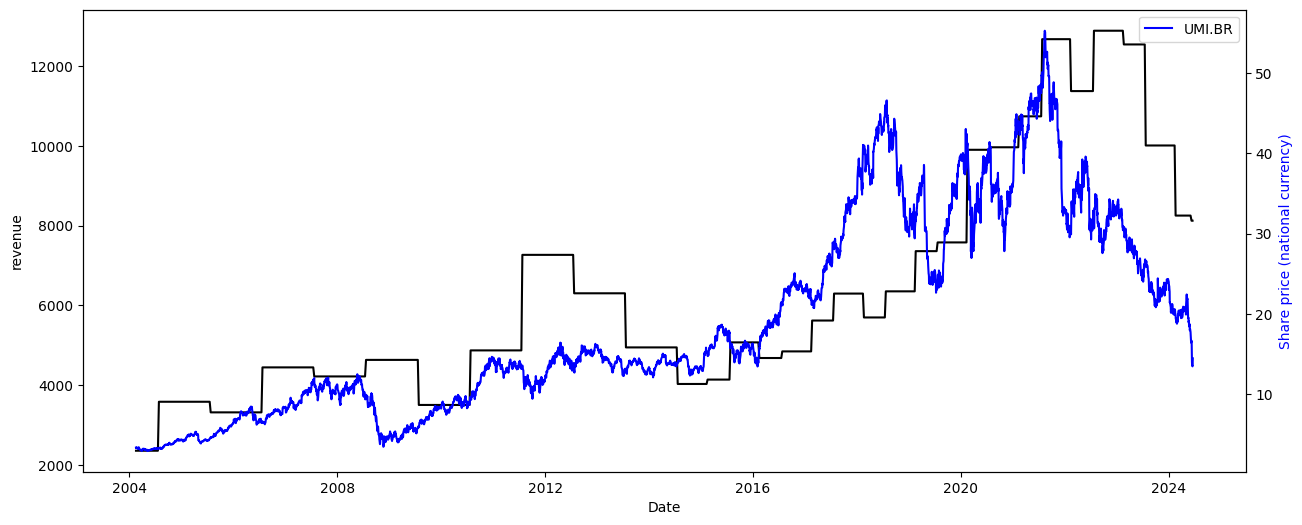

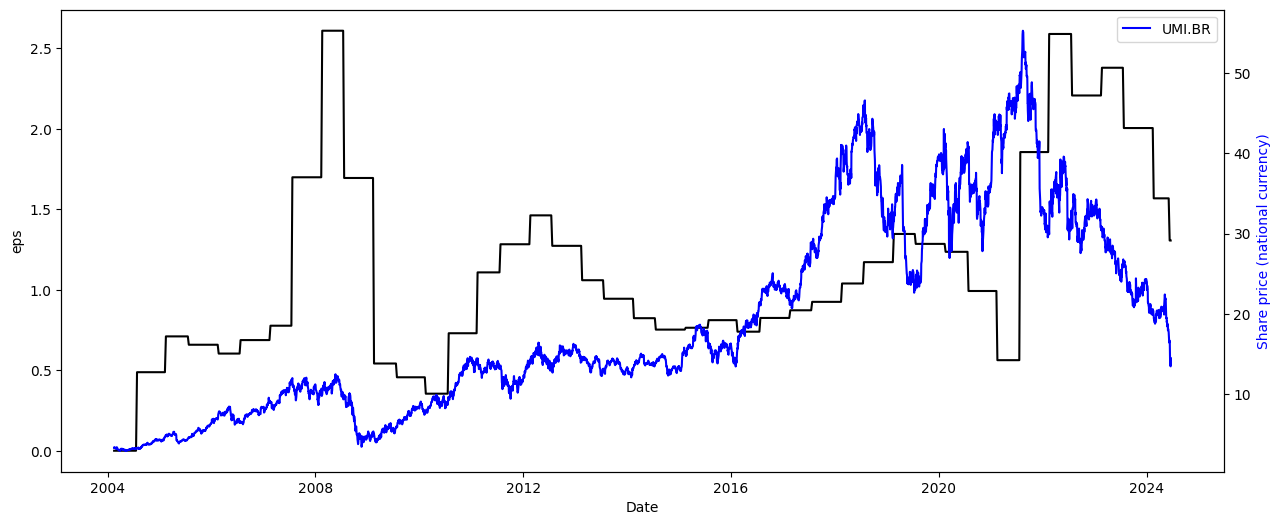

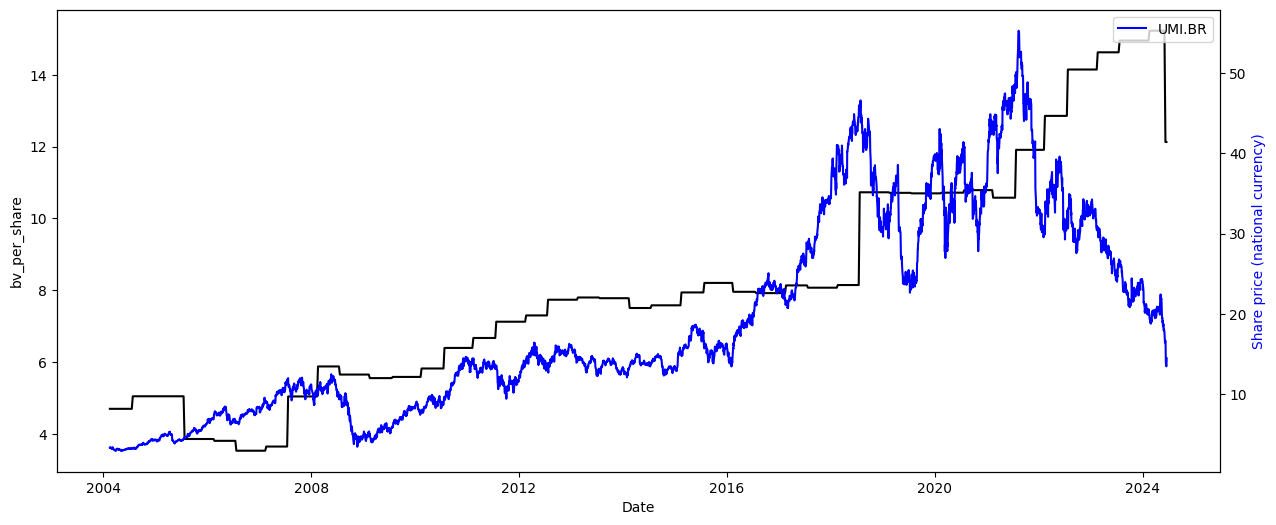

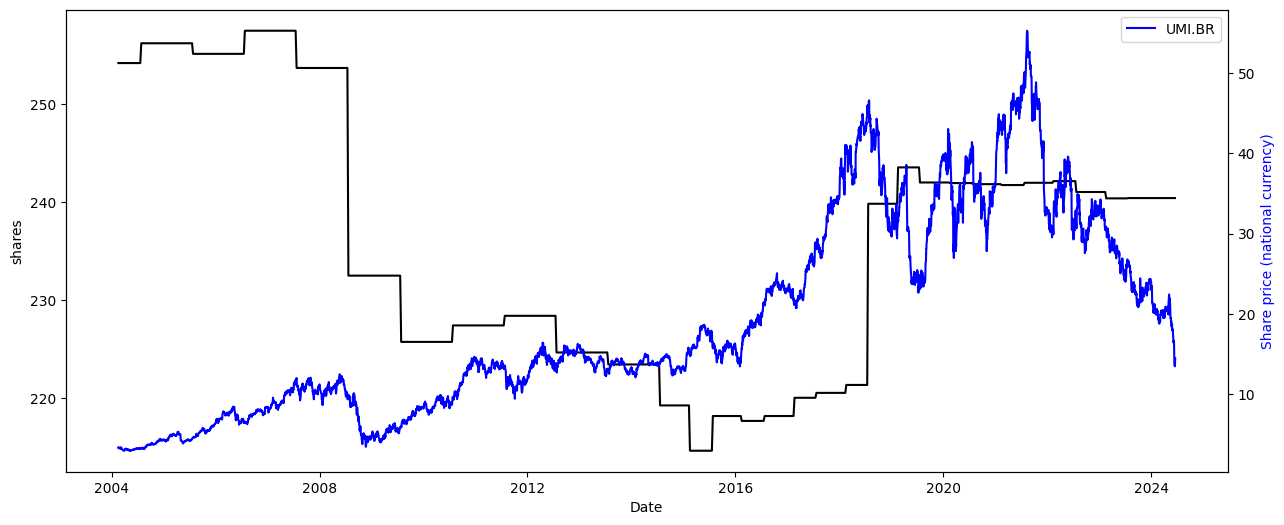

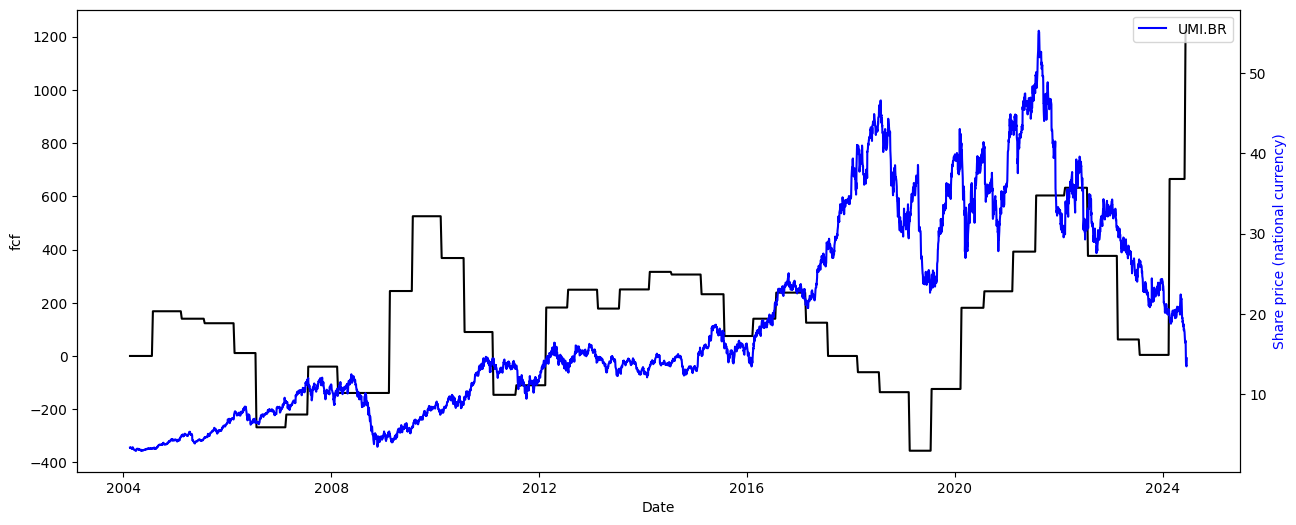

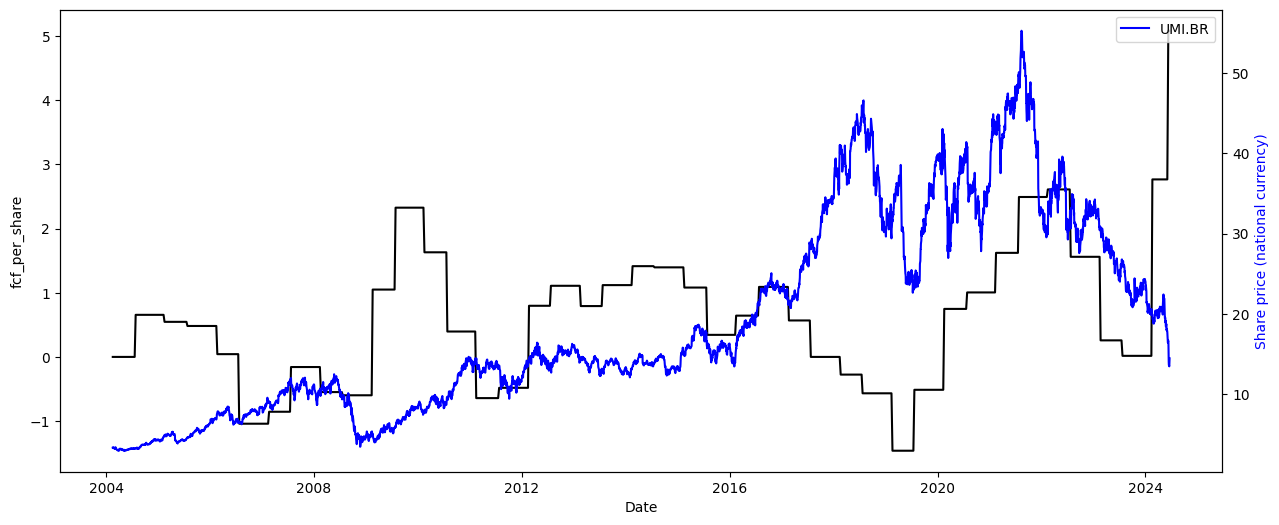

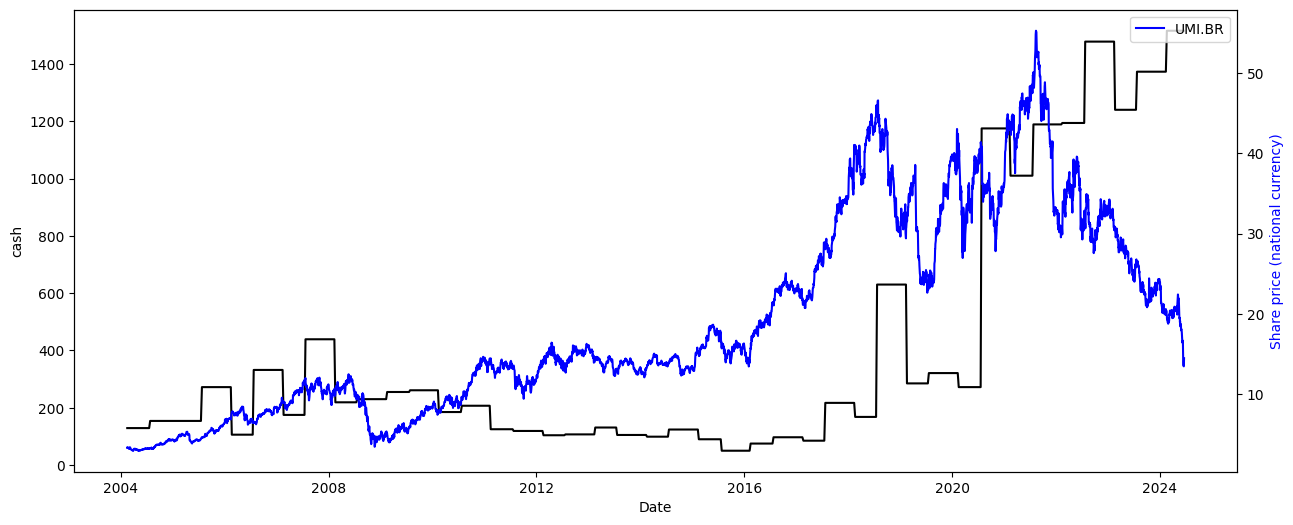

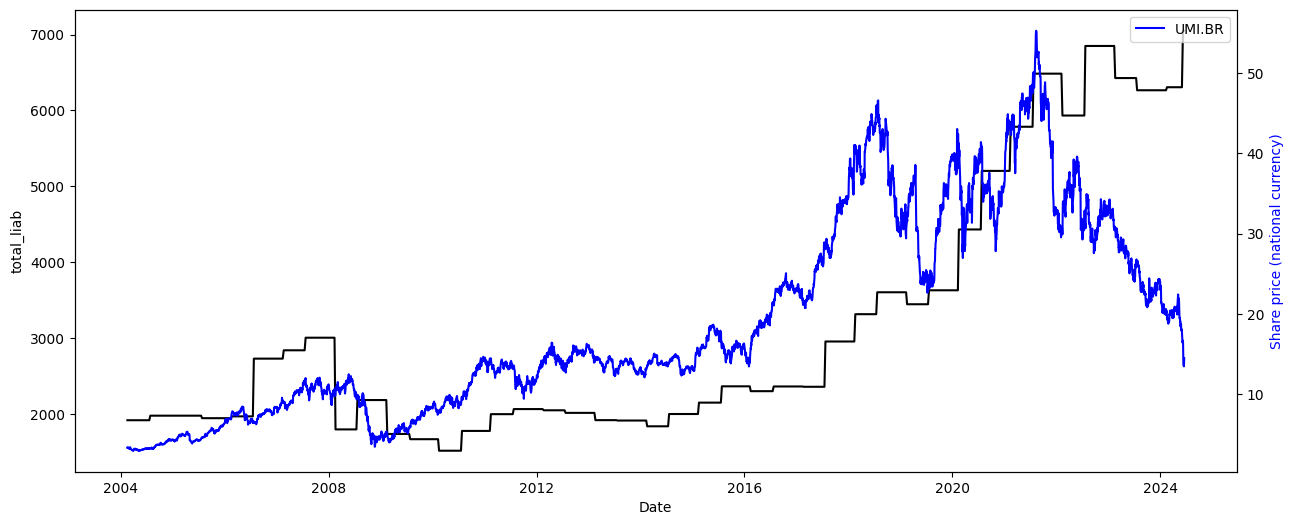

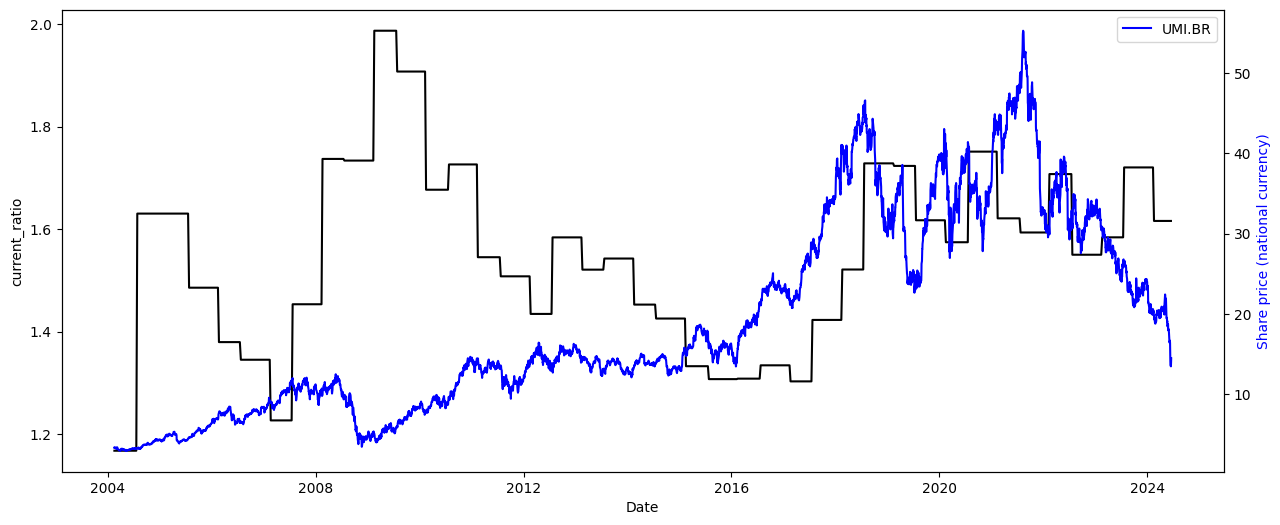

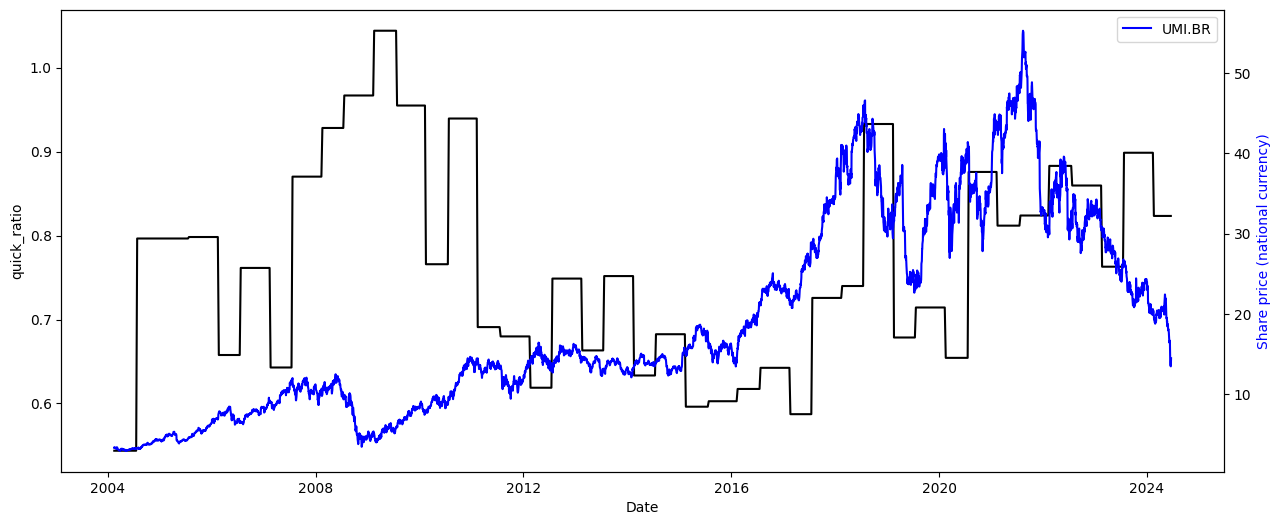

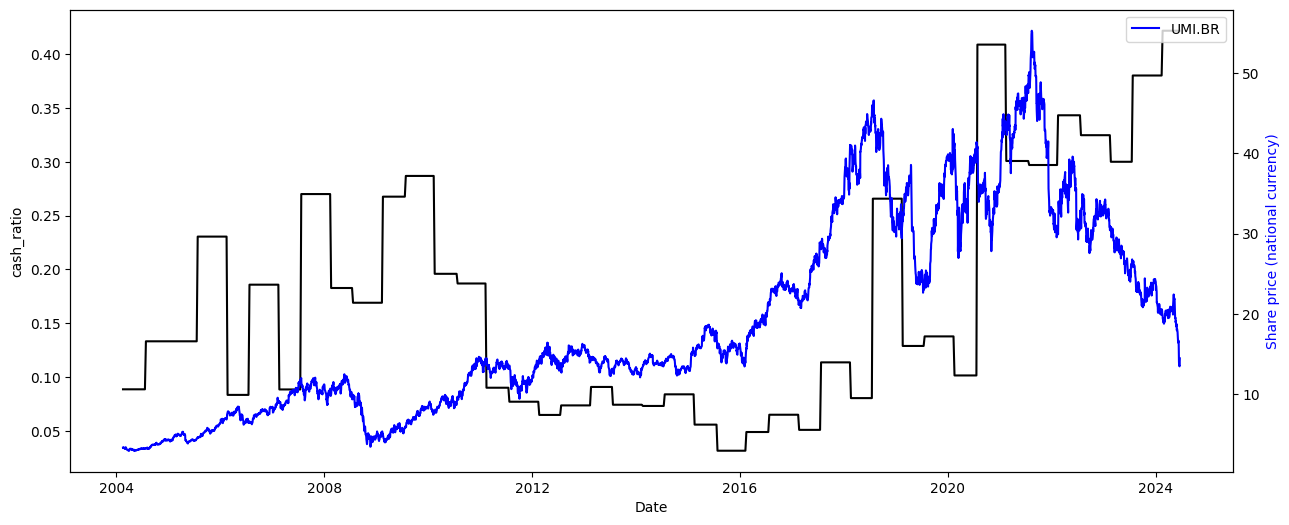

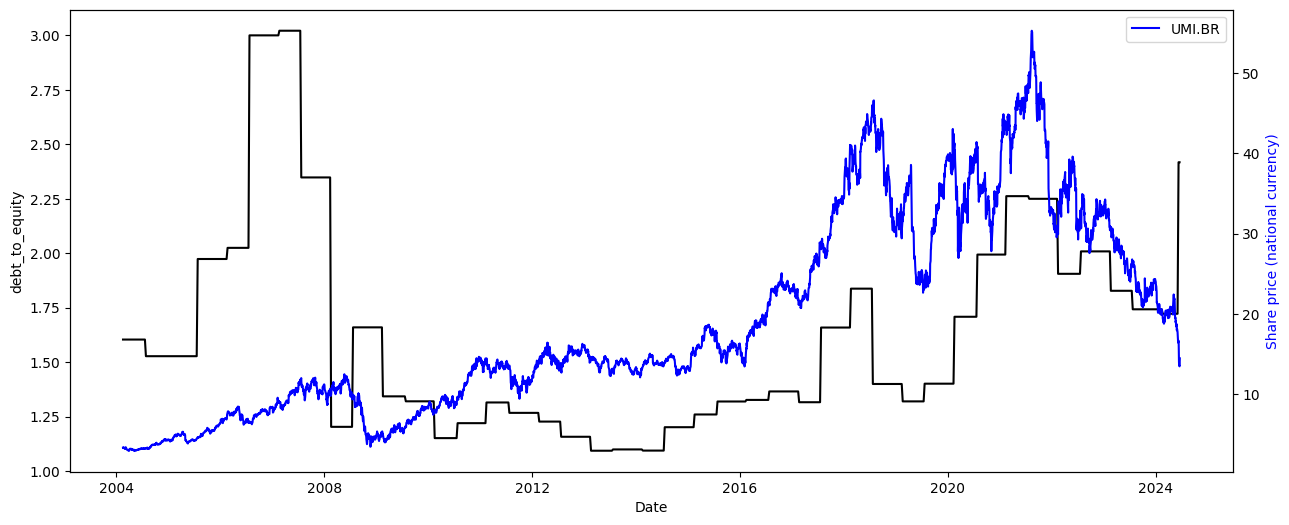

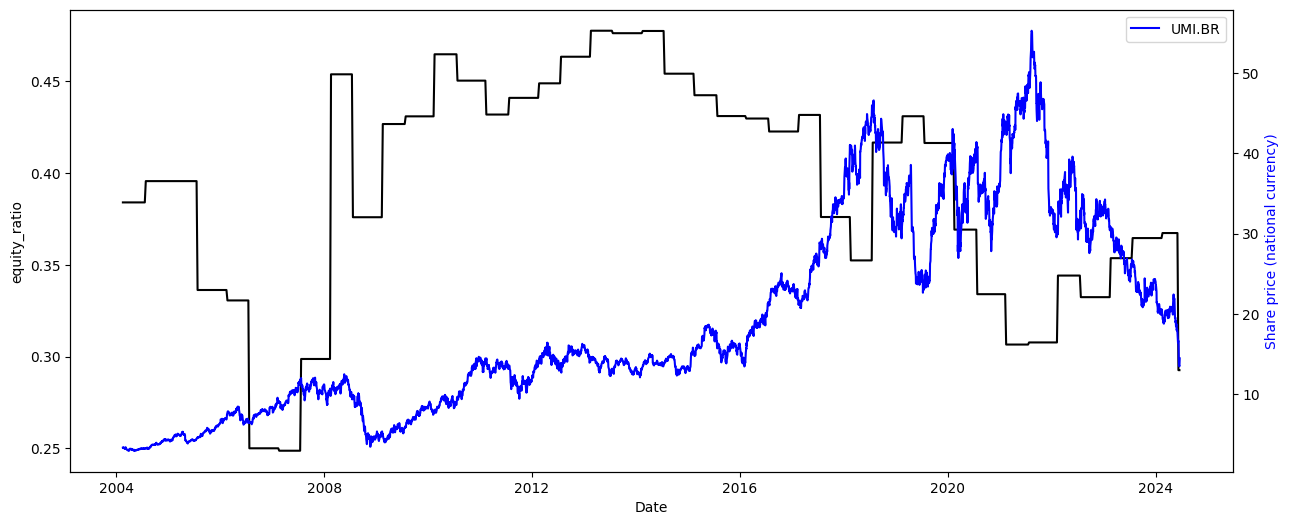

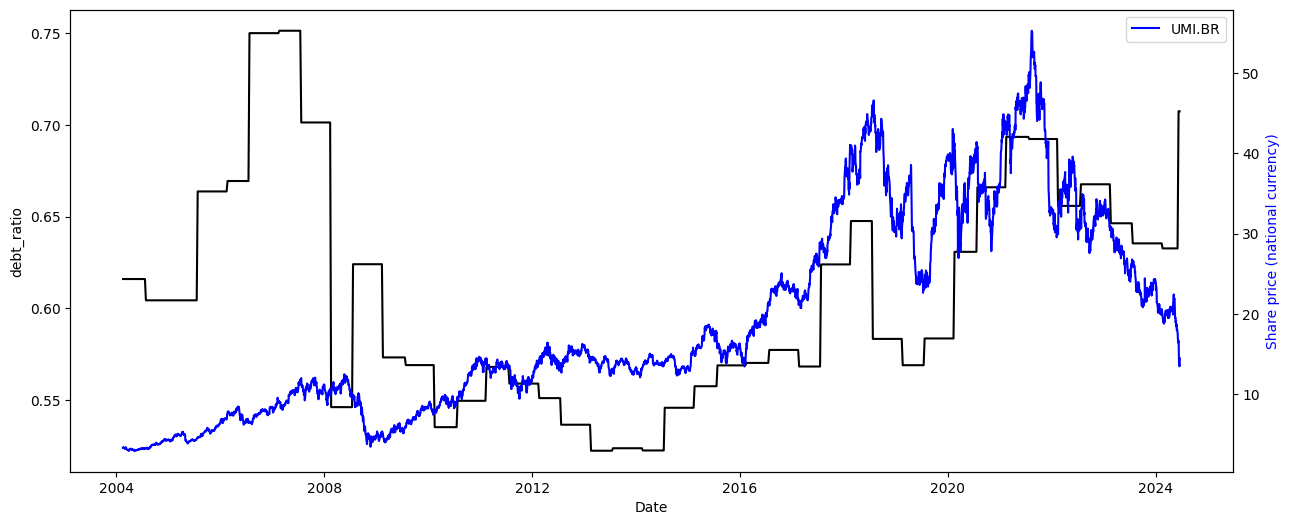

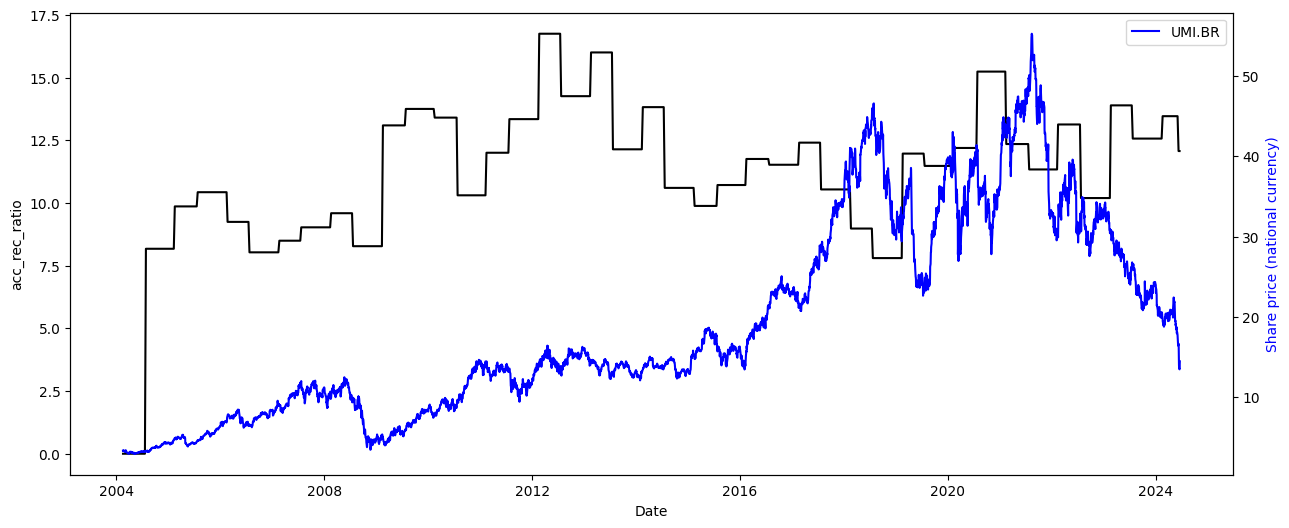

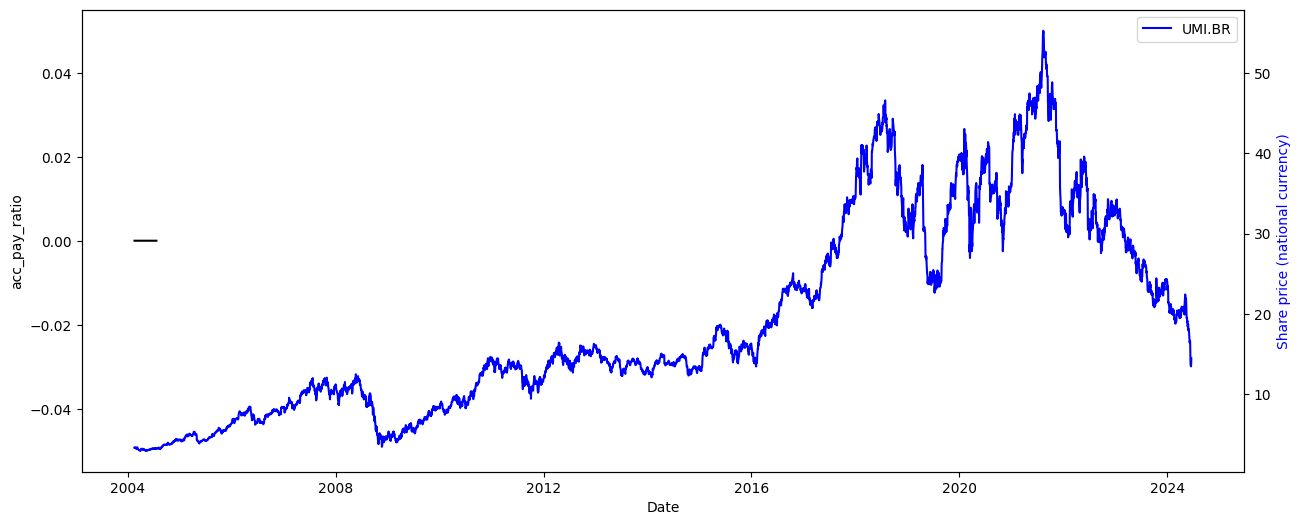

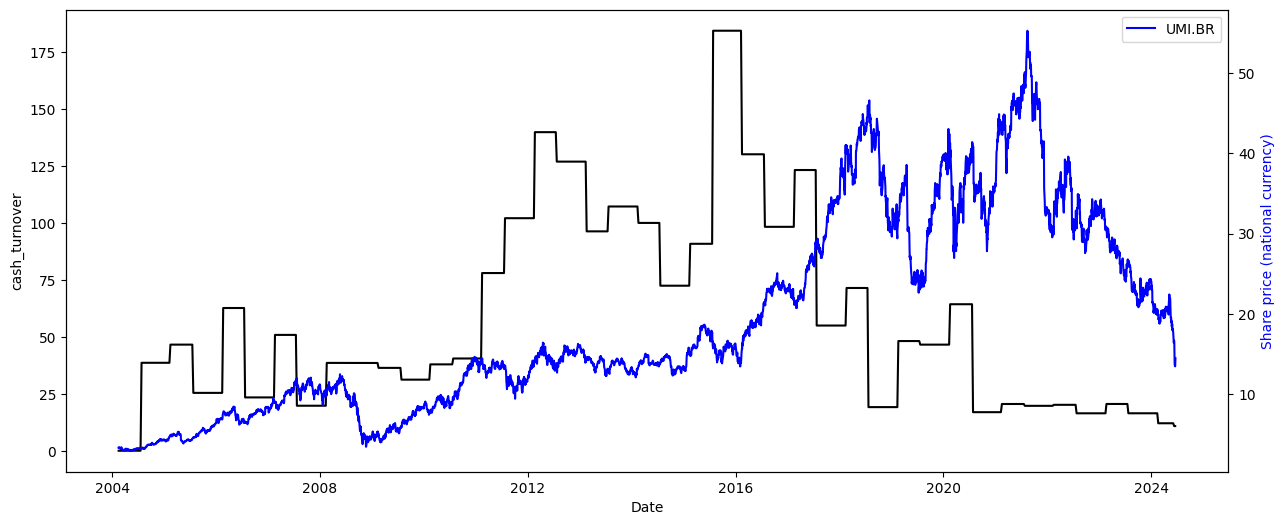

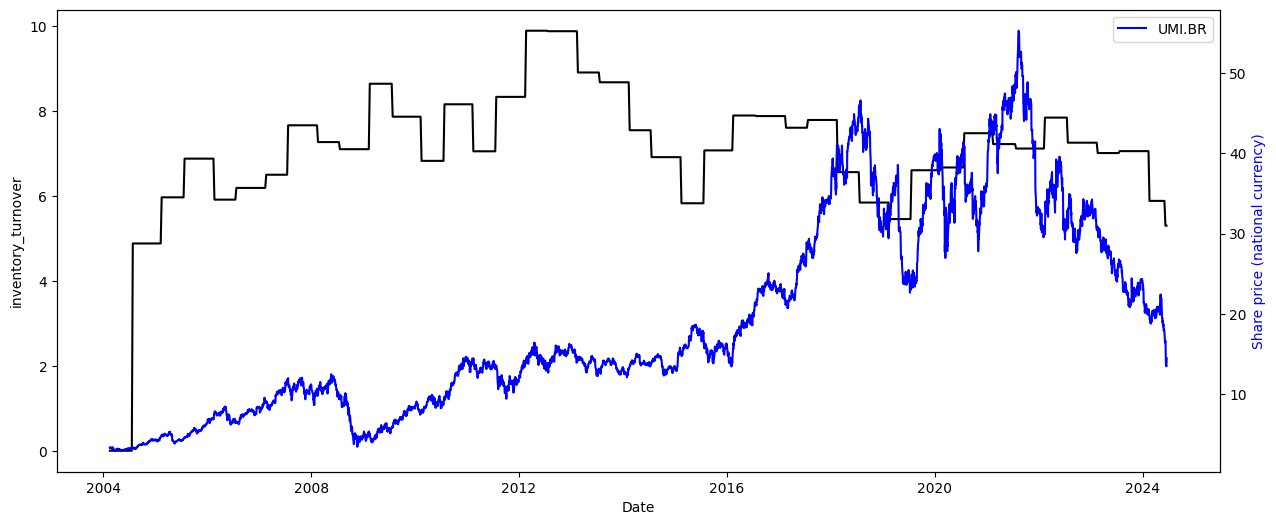

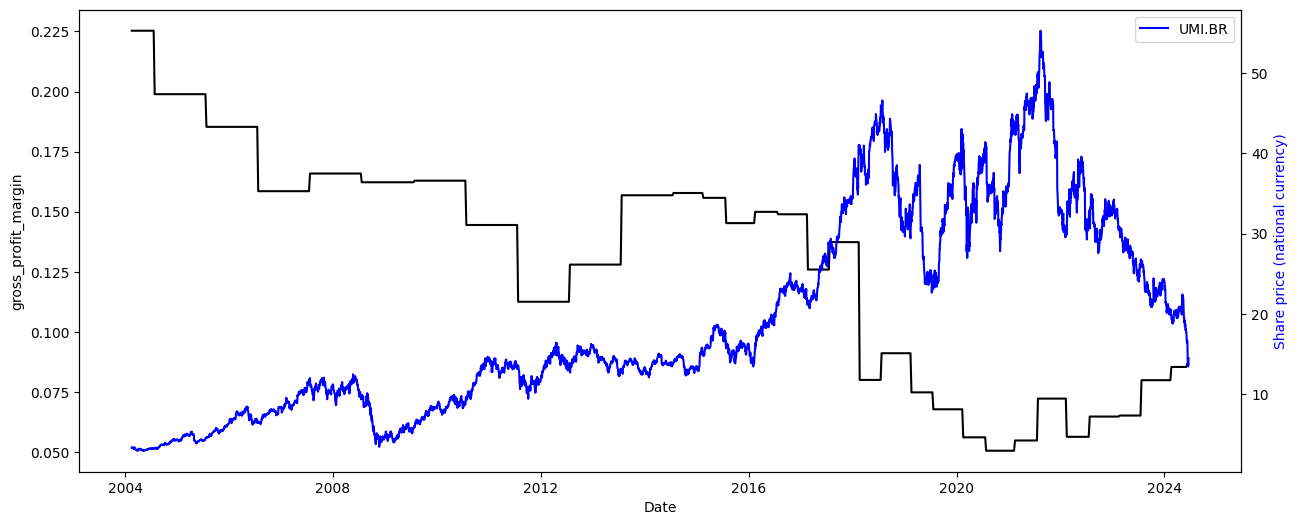

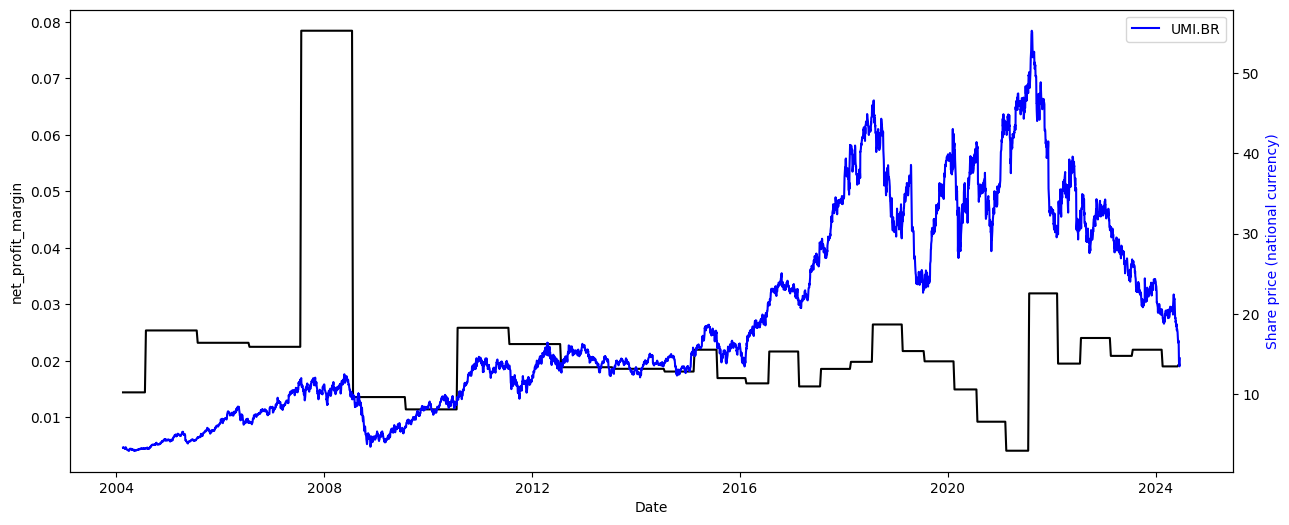

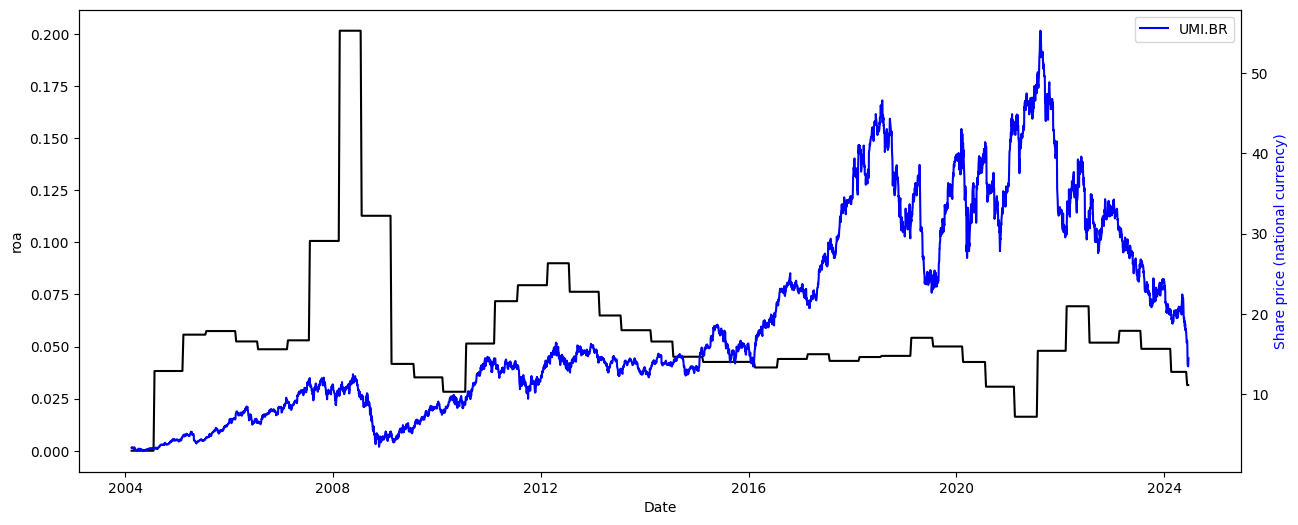

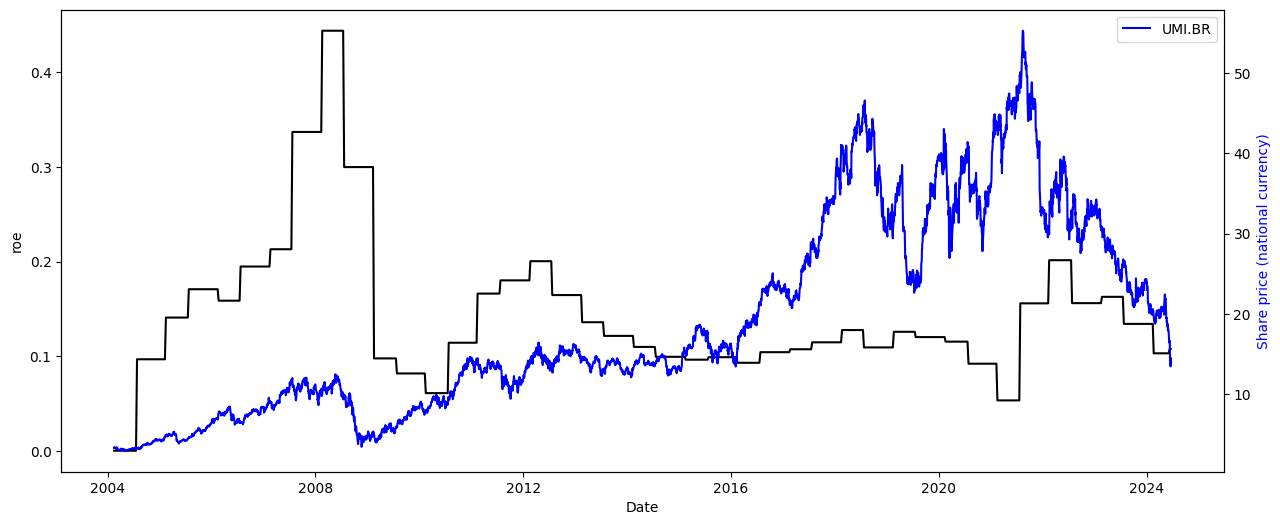

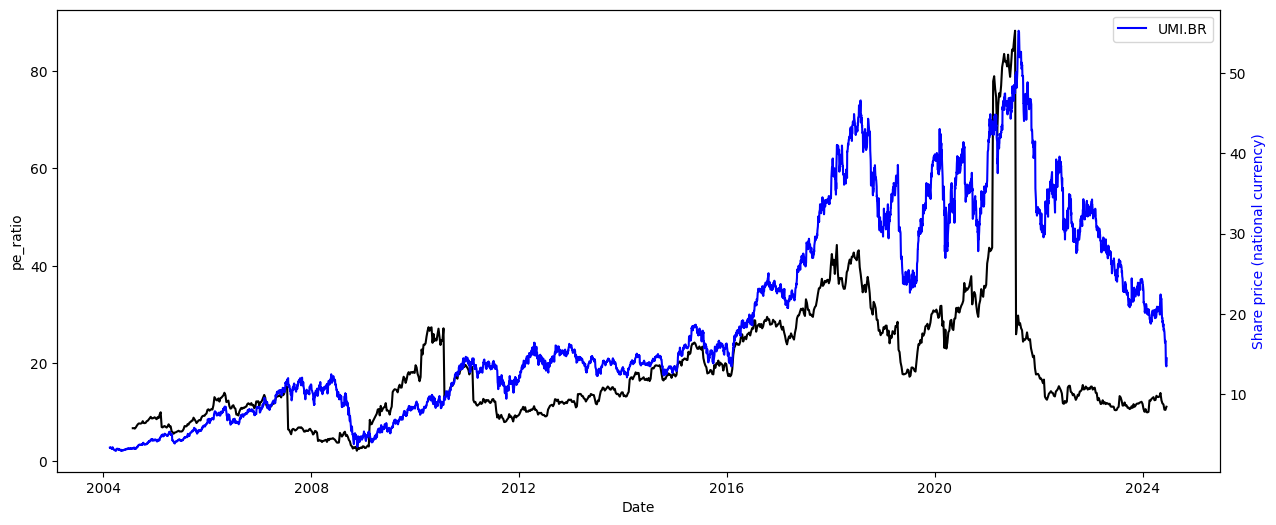

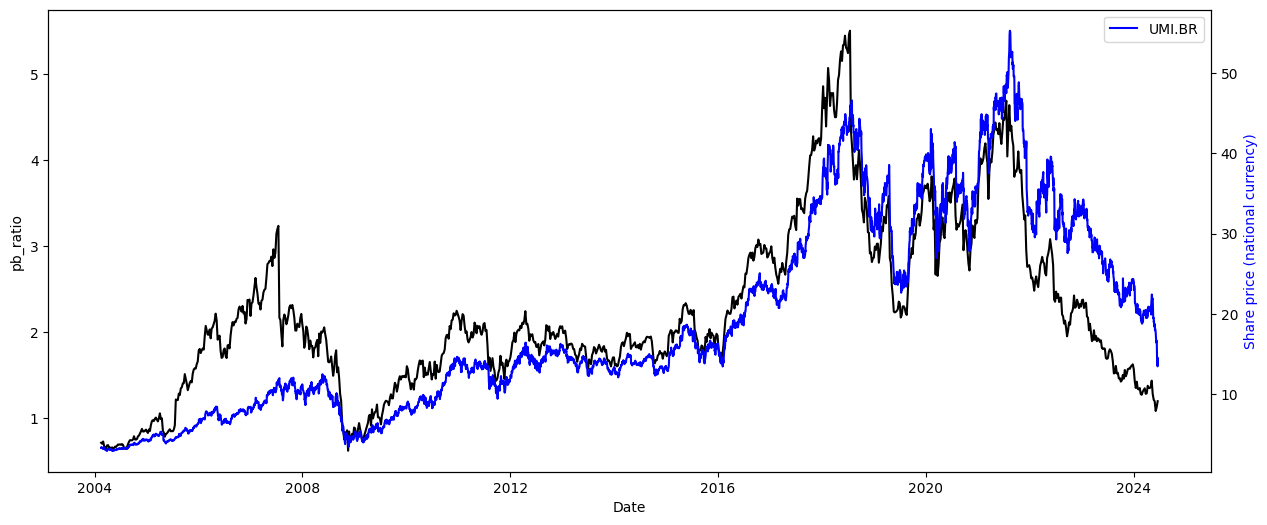

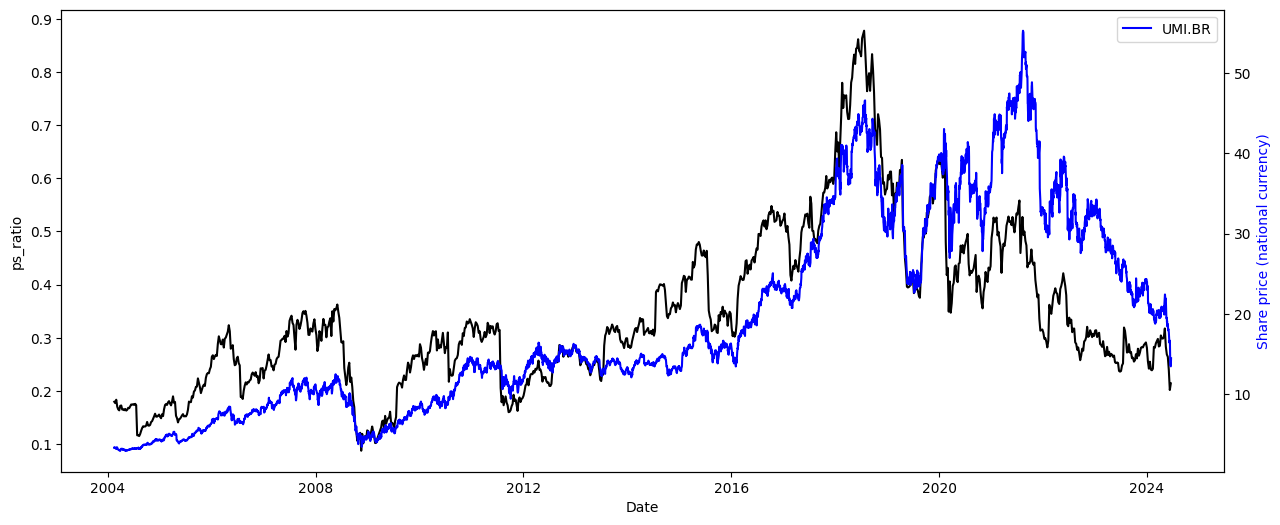

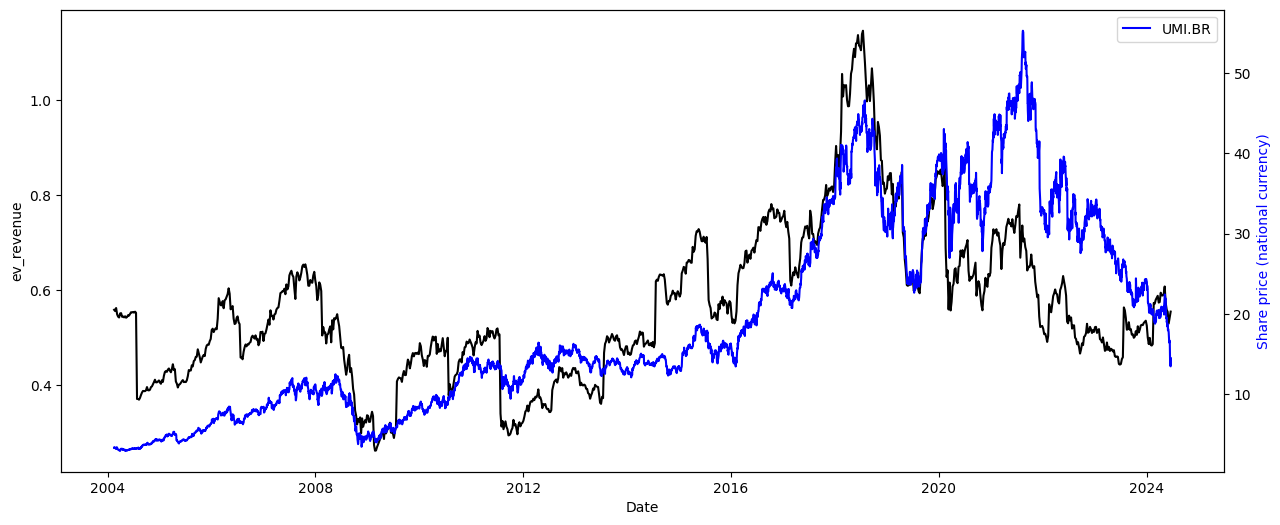

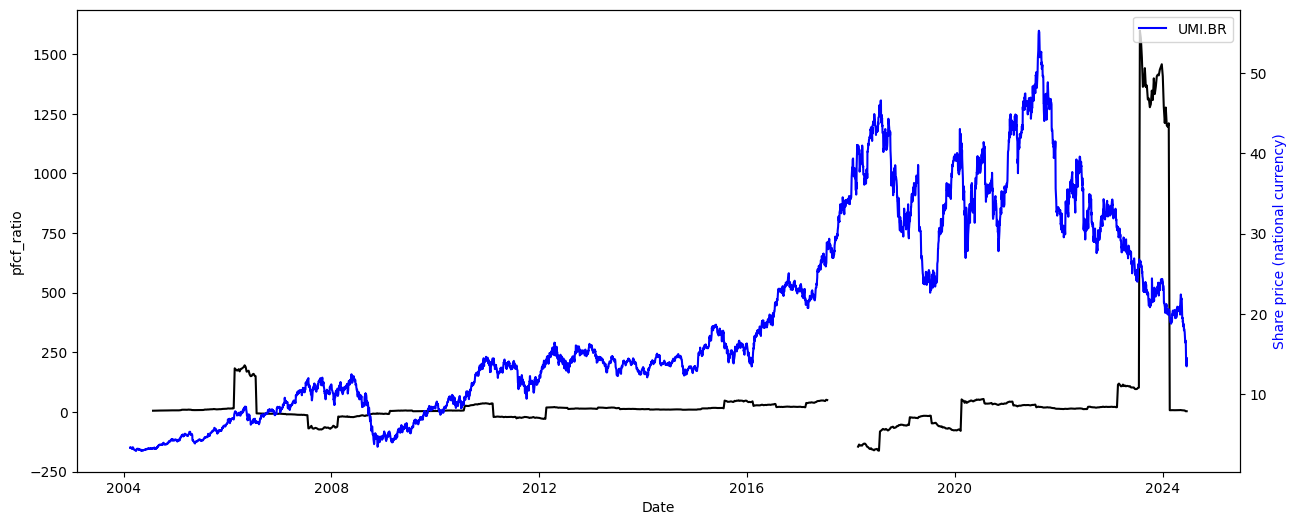

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

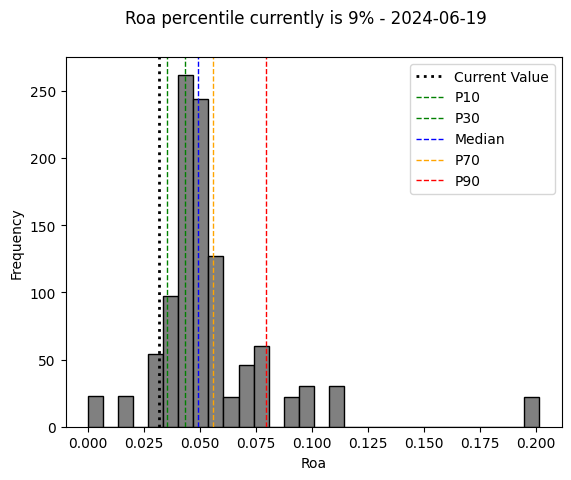

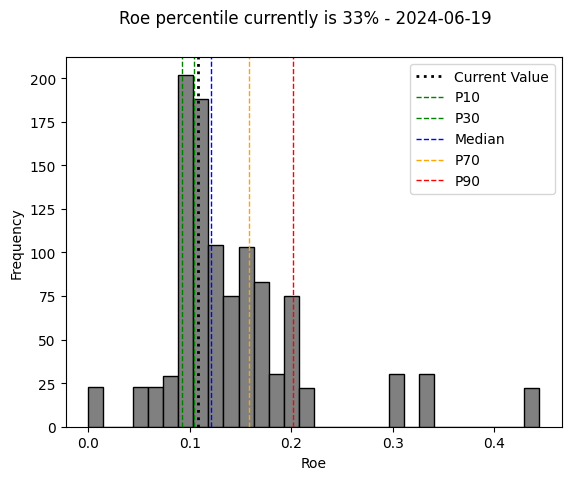

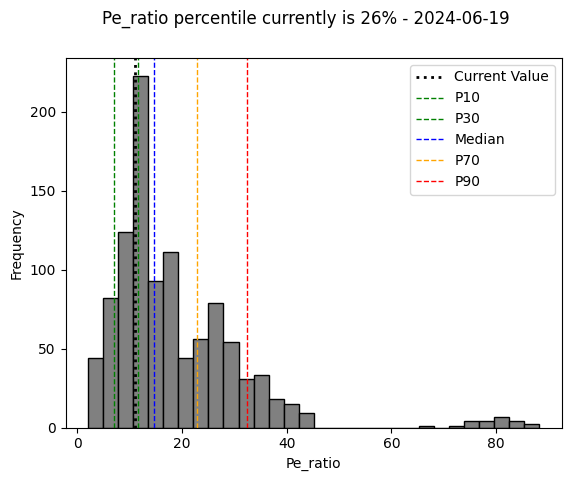

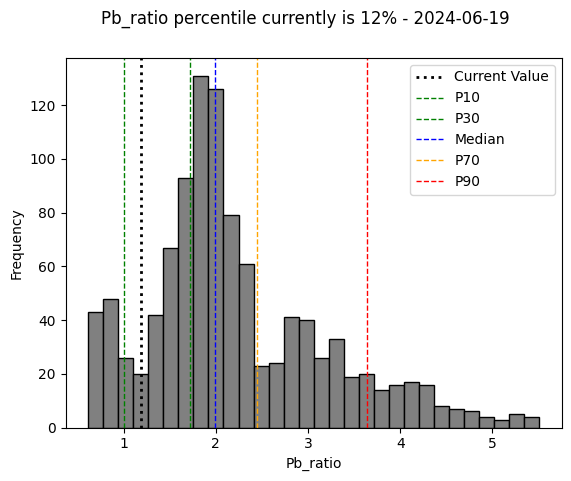

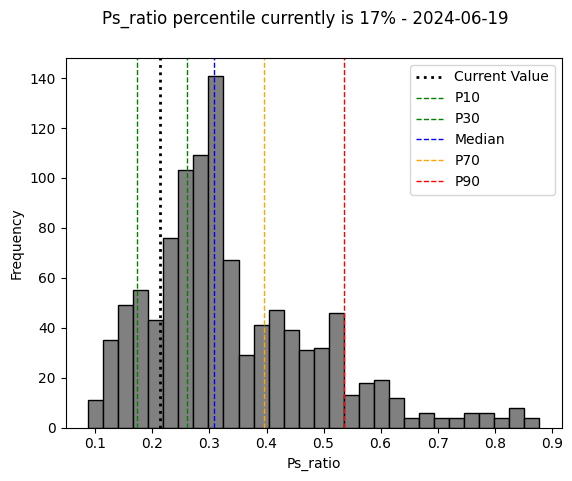

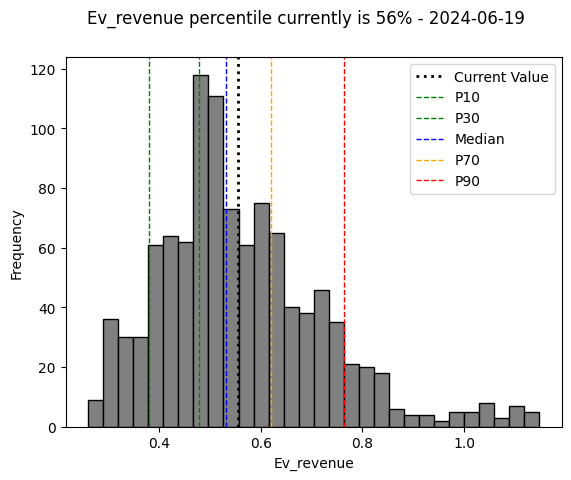

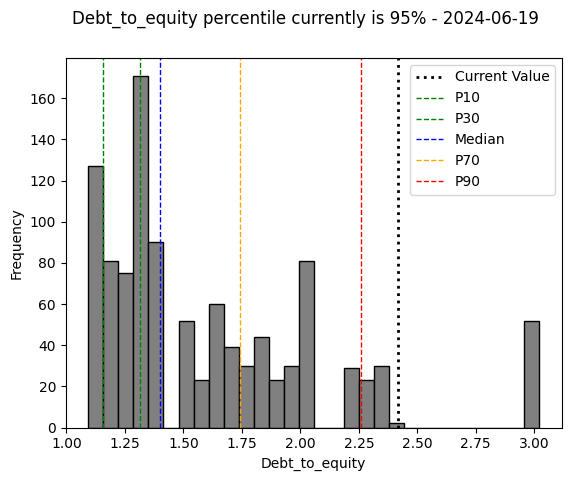

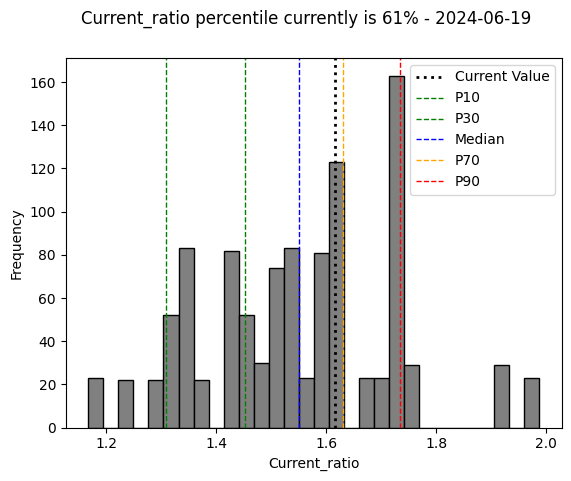

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.927171,-0.512179,-0.159269,-0.185455,-0.259908,-0.098214,0.167355
roe,0.927171,1.000000,-0.520500,-0.093333,-0.198091,-0.204316,0.252661,0.081740
pe_ratio,-0.512179,-0.520500,1.000000,0.780003,0.722344,0.673620,0.079721,-0.041600
pb_ratio,-0.159269,-0.093333,0.780003,1.000000,0.892556,0.828469,0.258013,-0.101137
ps_ratio,-0.185455,-0.198091,0.722344,0.892556,1.000000,0.955045,-0.019763,-0.090273
ev_revenue,-0.259908,-0.204316,0.673620,0.828469,0.955045,1.000000,0.143179,-0.213320
debt_to_equity,-0.098214,0.252661,0.079721,0.258013,-0.019763,0.143179,1.000000,-0.202924
current_ratio,0.167355,0.081740,-0.041600,-0.101137,-0.090273,-0.213320,-0.202924,1.000000


2 timestemos have been found!


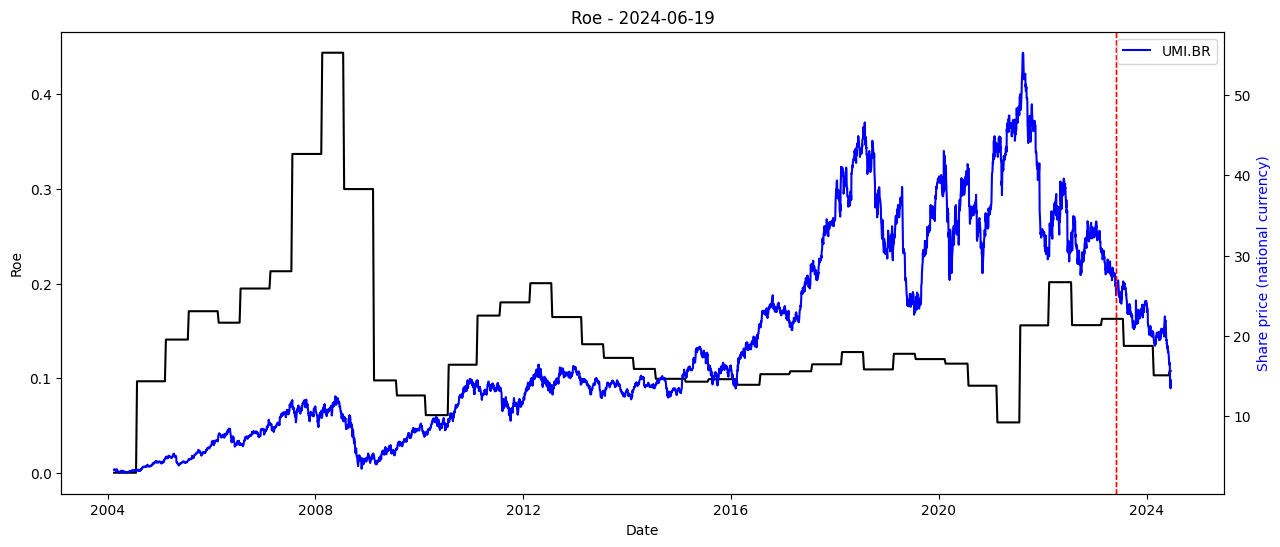

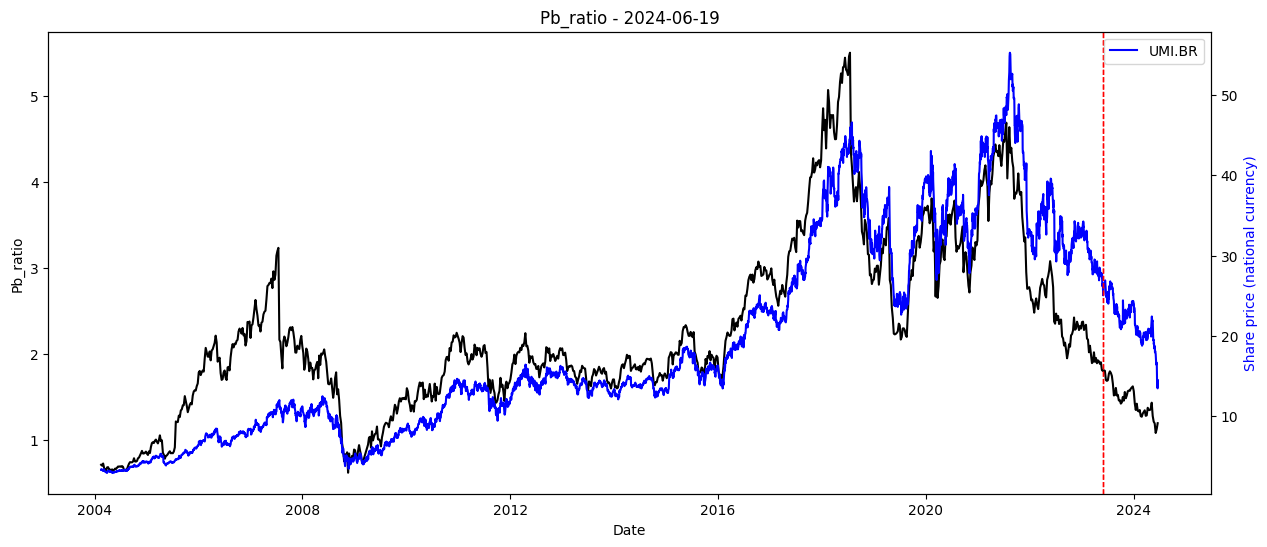

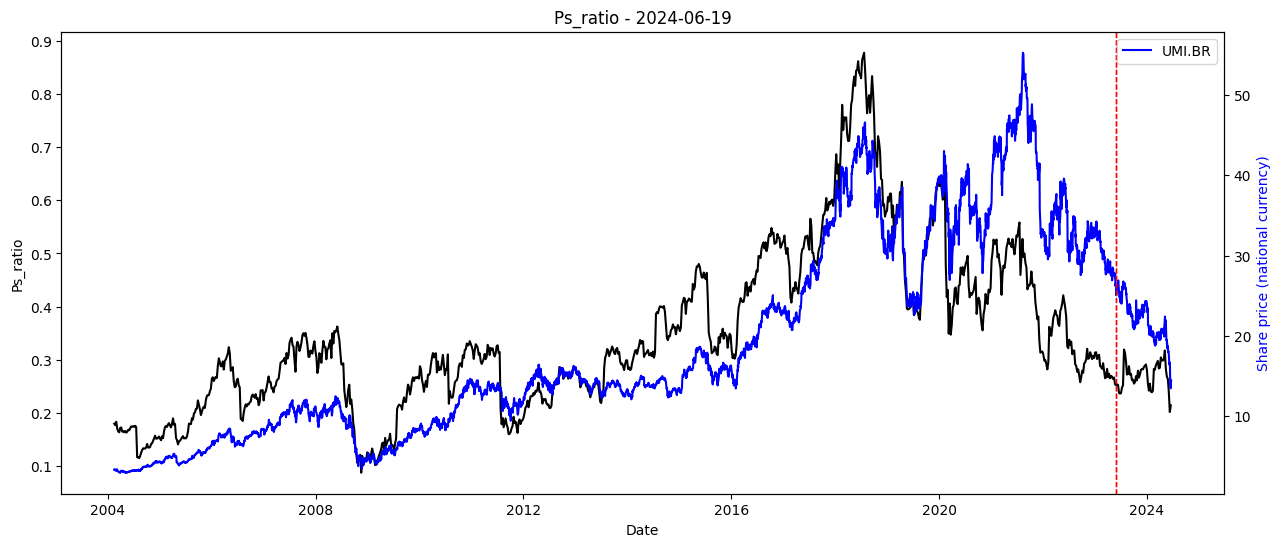

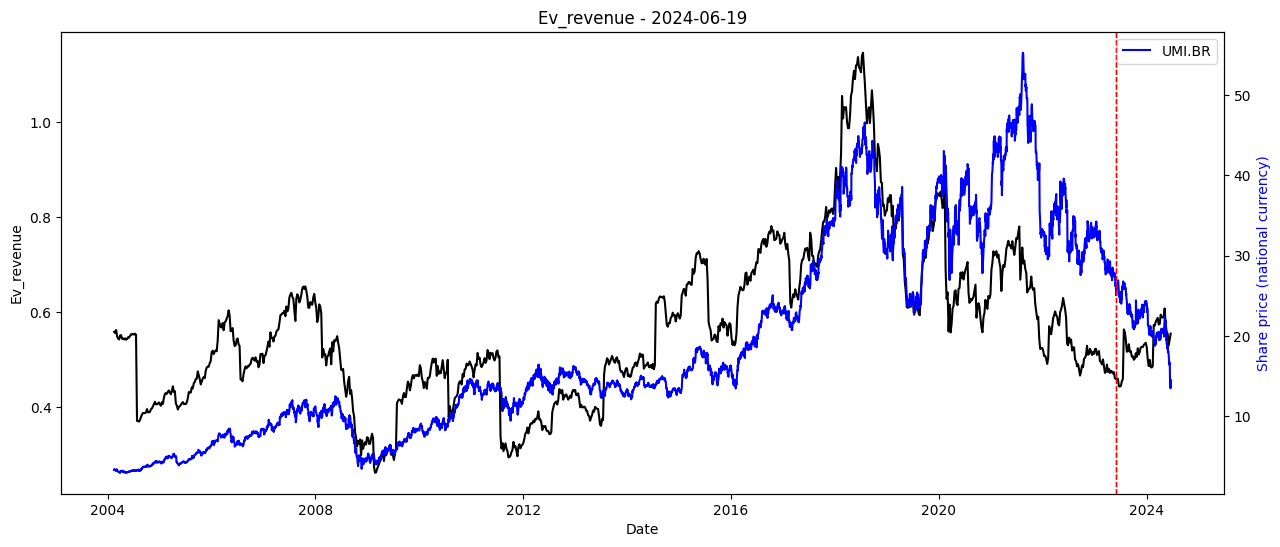

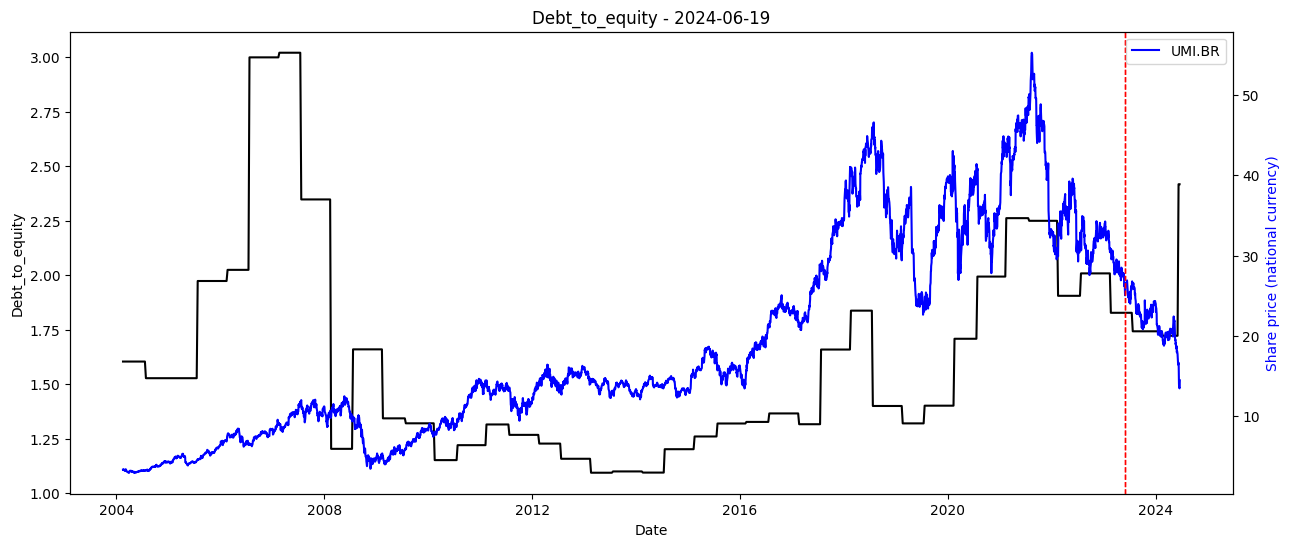

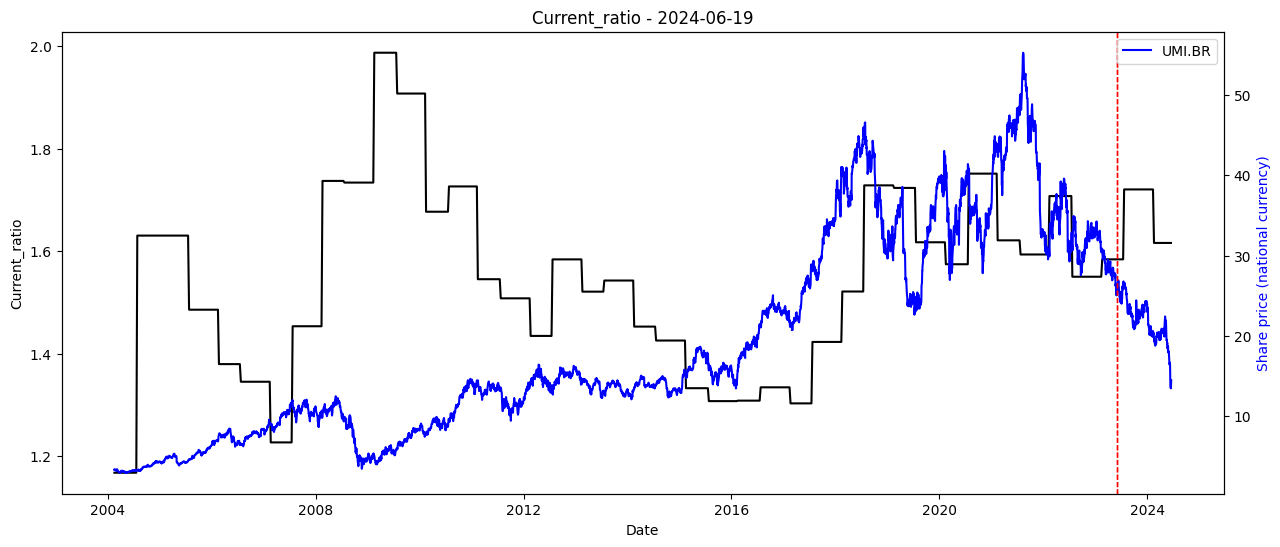

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )